In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from tqdm import tqdm
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version:  1.13.0+cpu
Torchvision Version:  0.14.0+cpu


In [2]:
# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 5

input_size = 224

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [3]:

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        l = []
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.unsqueeze(1).float().to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    preds = (outputs > 0.5).float()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), "best_model.pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else : 
        for param in model.parameters():
            param.requires_grad = True

In [5]:
def initialize_model( feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 1)
    

  
    return model_ft

# Initialize the model for this run
model_ft = initialize_model( feature_extract = False, use_pretrained=True)
#model_ft = torch.load('best_model.pth')
# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:

from PIL import Image

class MyDataset(torch.utils.data.Dataset):
  'Caractérise un jeu de données pour PyTorch'
  def __init__(self, transforms = None, root_dir = 'data', mode = 'train'):
        'Initialisation'
        self.df = pd.read_json(f"{root_dir}/{mode}.jsonl", lines=True)
        self.labels = self.df.label
        self.image_names = self.df.img
        self.transforms = transforms
        self.root_dir = root_dir
#       print(len(self.labels[self.labels == 0])/len(self.labels))
      
  def __len__(self):
        "Représente le nombre total d'exemples du jeu de données"
        return len(self.labels)

  def __getitem__(self, idx):
      'Génère un exemple à partir du jeu de données'
      # Sélection de l'exemple
      if torch.is_tensor(idx):
            idx = idx.tolist()

      image_path = f"{self.root_dir}/{self.image_names.iloc[idx]}"

      img = Image.open(image_path).convert('RGB')

      if self.transforms :
            img = self.transforms(img)

      return img, self.labels.iloc[idx]

In [7]:

# Data augmentation and normalization for training
# Just normalization for validation

alpha_buster = lambda x: x[:3, :, :]


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        alpha_buster
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        alpha_buster
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
#image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
image_datasets = {x: MyDataset(transforms = data_transforms[x], mode = x) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Initializing Datasets and Dataloaders...
cpu


In [8]:
# Send the model to GPU
model_ft = model_ft.to(device)


print("Params to learn:")
params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)


# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [9]:
# Setup the loss fxn
criterion = nn.BCEWithLogitsLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/4
----------


100%|██████████| 1063/1063 [19:02<00:00,  1.07s/it]


train Loss: 0.6934 Acc: 0.6344


100%|██████████| 63/63 [00:28<00:00,  2.18it/s]


val Loss: 0.9150 Acc: 0.4980
Epoch 1/4
----------


100%|██████████| 1063/1063 [19:18<00:00,  1.09s/it]


train Loss: 0.6794 Acc: 0.6385


100%|██████████| 63/63 [00:32<00:00,  1.96it/s]


val Loss: 0.7260 Acc: 0.5040
Epoch 2/4
----------


100%|██████████| 1063/1063 [20:59<00:00,  1.18s/it]


train Loss: 0.6772 Acc: 0.6416


100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


val Loss: 0.9351 Acc: 0.5020
Epoch 3/4
----------


100%|██████████| 1063/1063 [20:19<00:00,  1.15s/it]


train Loss: 0.6726 Acc: 0.6404


100%|██████████| 63/63 [00:30<00:00,  2.09it/s]


val Loss: 0.7015 Acc: 0.5280
Epoch 4/4
----------


100%|██████████| 1063/1063 [18:52<00:00,  1.07s/it]


train Loss: 0.6713 Acc: 0.6416


100%|██████████| 63/63 [00:26<00:00,  2.37it/s]

val Loss: 0.9216 Acc: 0.4940
Training complete in 100m 58s
Best val Acc: 0.528000


AUC-ROC : 0.5647


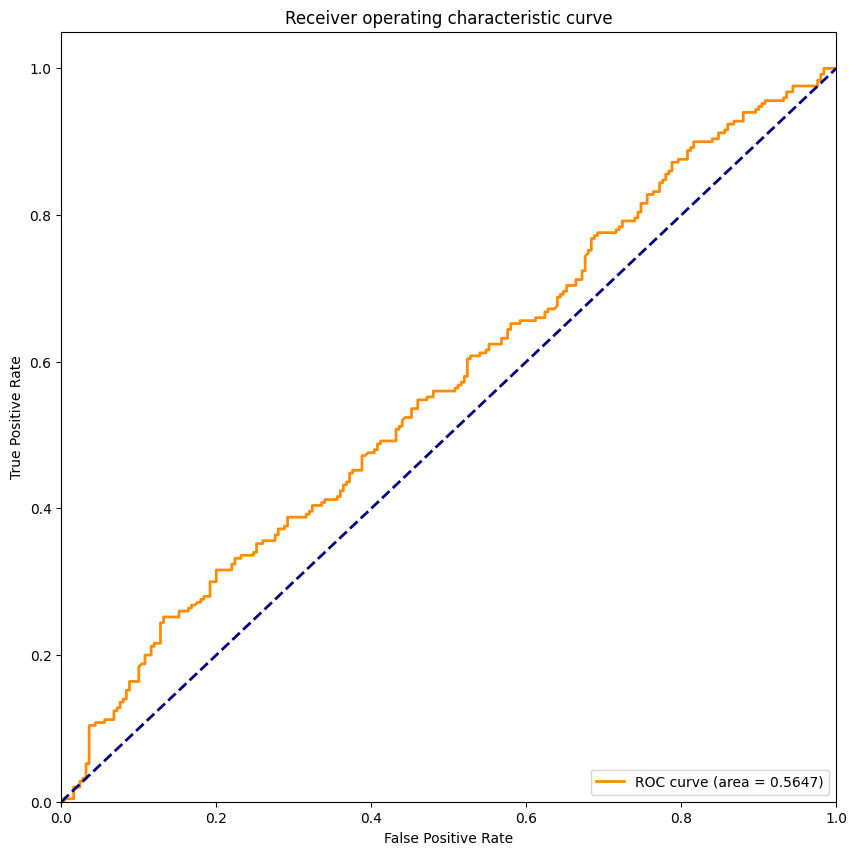

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score



# Prédire les probabilités pour les données de test
model_ft.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for inputs, labels in dataloaders_dict['val']:
        outputs = model_ft(inputs)
        y_pred.extend(torch.sigmoid(outputs).numpy())
        y_true.extend(labels.numpy())


# Calculer l'AUC-ROC
auc_roc = roc_auc_score(y_true, y_pred)
print("AUC-ROC : {:.4f}".format(auc_roc))

# Calculer la courbe ROC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()